In [1]:
import h5py

types = [
    "stimulation_only",
    "stimulation_saline",
    "stimulation_low_cckglp1",
    "stimulation_high_cckglp1",
]

data_stim = None
with h5py.File('data/i2Move/vn_data.h5', 'r') as frequency:
    data_stim = frequency['stimulation_only']
    data = data_stim['time_series_data'][:]
    labels = data_stim['labels'][:]
    info = data_stim['info'][:].astype(str)  # Convert byte strings back to normal strings

In [2]:
print('Data shape:', data.shape)
print('Labels shape:', labels.shape)
print('Info shape:', info.shape)

In [3]:
import numpy as np

fs = 20000
Ts = 1/fs

Ts_new = 0.0001

t = np.arange(0, len(data[0, :])) * Ts

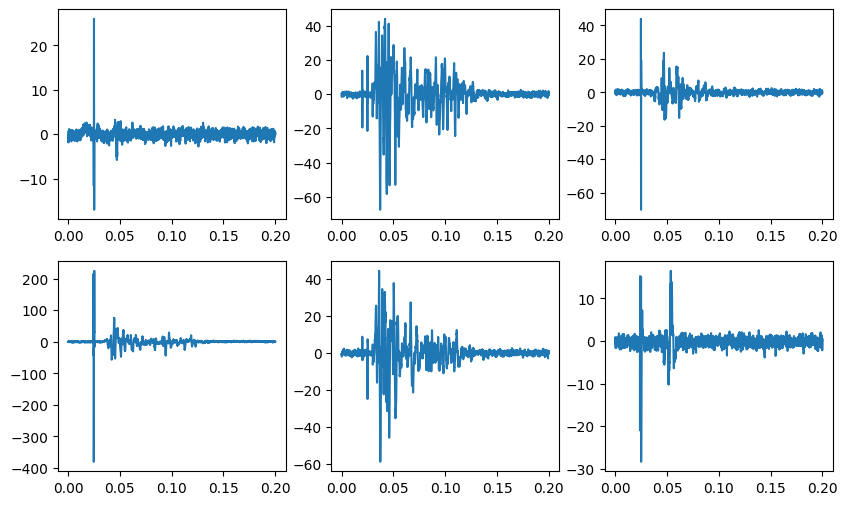

In [4]:
# downsample by 2, take every 2nd sample
t = t[::2]

responses = data[:, ::2]
responses.shape

# plto some random data
import matplotlib.pyplot as plt

random_idx = np.random.randint(0, responses.shape[0], 6)

plt.figure(figsize=(10, 6))
for i, idx in enumerate(random_idx):
    plt.subplot(2, 3, i+1)
    plt.plot(t, responses[idx])
plt.show()

In [5]:
# remove last value of t and data
t = t[:-1]
responses = responses[:, :-1]

Data shape: (976, 4001)
Labels shape: (976, 2)
Info shape: (976,)


In [6]:
from scipy.signal import butter, filtfilt

def lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def remove_stim_artefacts(response, cutoff, fs, order=6):
    response_filt = lowpass_filter(response, cutoff, fs, order)
    return response_filt

# remove stimulation artefacts from all responses
fs = 1/(Ts_new) # Sampling frequency in Hz
cutoff = 250
order = 6
filtered_responses = responses.copy()
for sid in range(0, len(filtered_responses)):
    response = responses[sid]
    filtered_responses[sid] = remove_stim_artefacts(response, cutoff, fs, order)

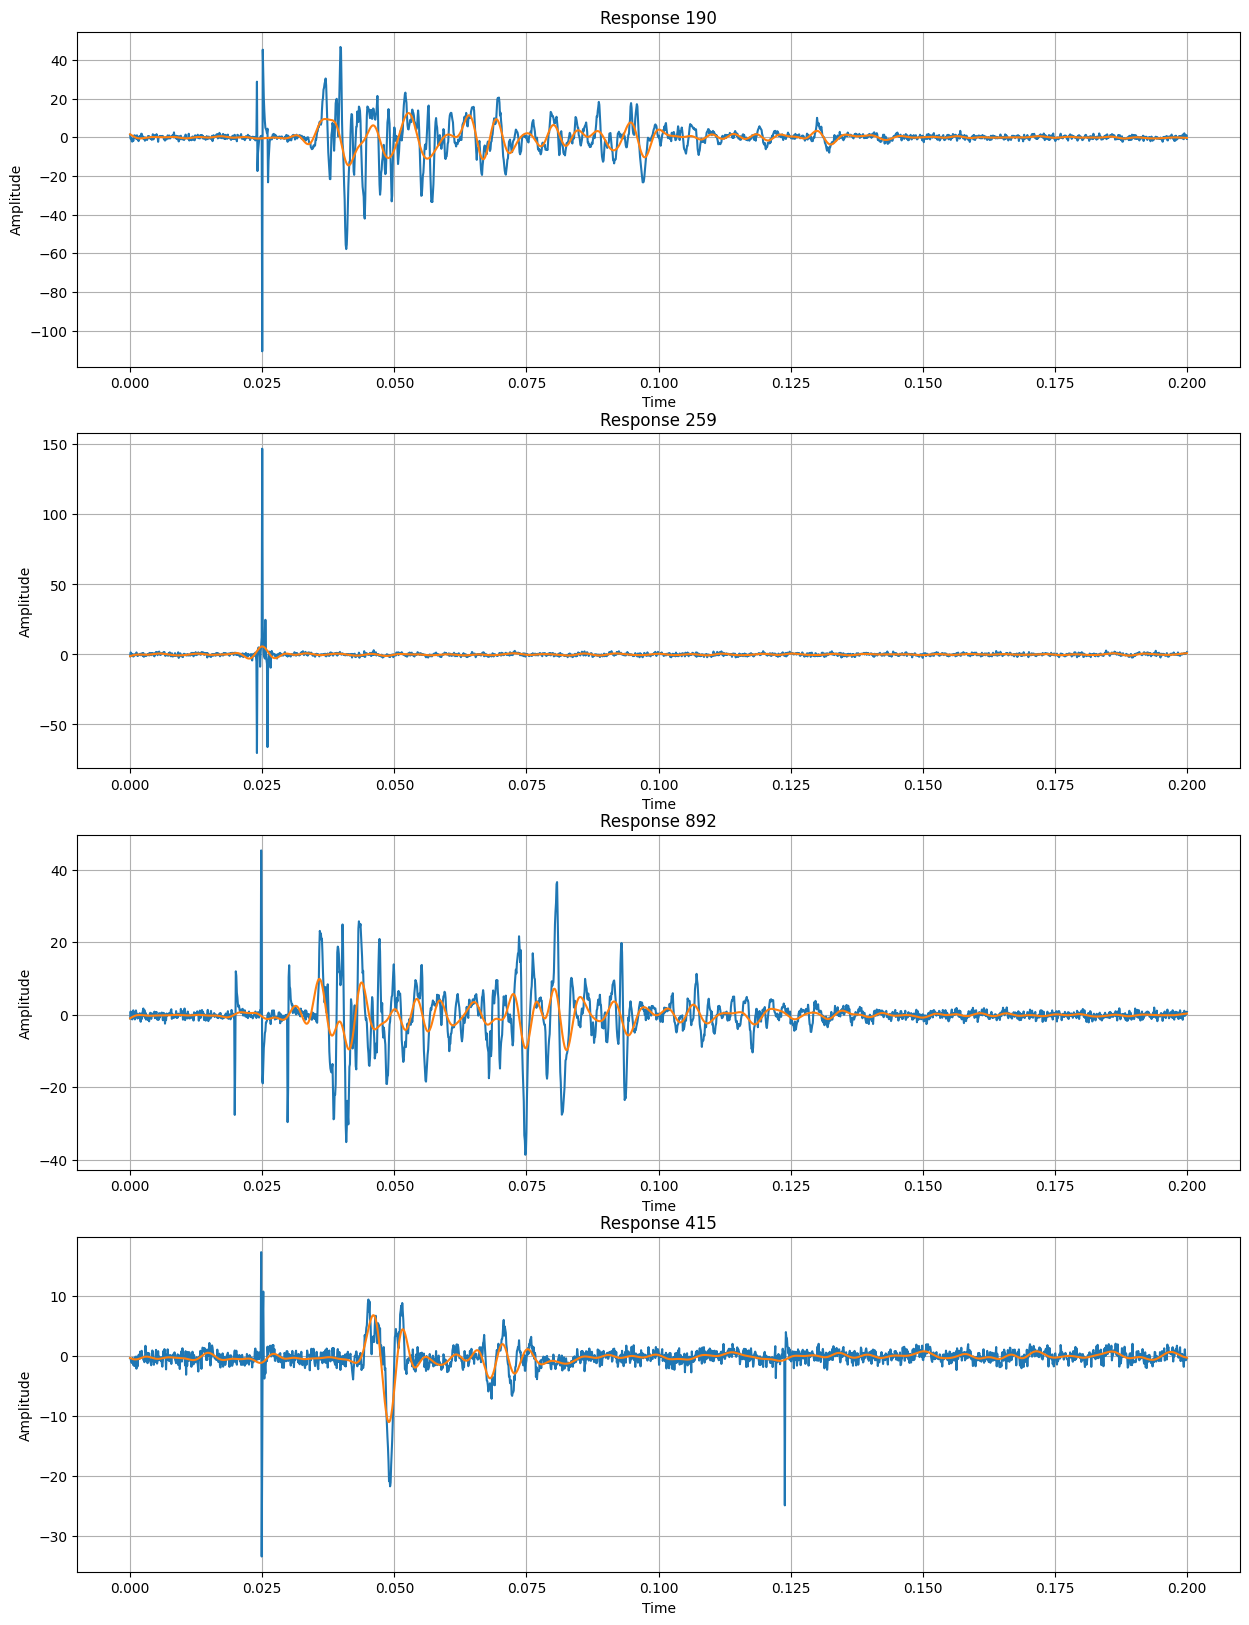

In [19]:
random_id = np.random.randint(0, len(responses), 4)

fig, ax = plt.subplots(4, 1, figsize=(15, 20))

for i, id in enumerate(random_id):
    ax[i].plot(t, responses[id])
    ax[i].plot(t, filtered_responses[id])
    ax[i].set_title('Response {}'.format(id))
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Amplitude')
    ax[i].grid(True)

In [ ]:
padded_responses = np.zeros((filtered_responses.shape[0], 2500))
for i in range(0, len(filtered_responses)):
    padded_responses[i, 0:len(filtered_responses[i])] = filtered_responses[i]

# create df and save as csv
import pandas as pd

df = pd.DataFrame(padded_responses)

df.to_csv('data/i2Move/vn_data_filtered.csv', index=False)

In [18]:
import numpy as np

def generate_biphasic_pulse(Ts, L, frequency, pulse_width, amplitude):
    """
    Generate and plot a biphasic pulse.

    Parameters:
    Ts (float): Sampling period in seconds.
    L (int): Length of the signal (number of samples).
    frequency (float): Frequency of the biphasic pulse in Hz.
    pulse_width (float): Pulse width in seconds.
    amplitude (float): Current amplitude.

    Returns:
    t (np.ndarray): Time vector.
    signal (np.ndarray): Generated biphasic pulse signal.
    """
    # Generate time vector
    t = np.arange(0, L*Ts, Ts)

    # Initialize the signal
    signal = np.zeros_like(t)

    # Calculate the period of the pulse
    T_pulse = 1 / frequency

    # Generate the biphasic pulse
    for i in range(len(t)):
        # Determine the position within the pulse period
        pos_in_period = t[i] % T_pulse
        
        if pos_in_period < pulse_width:
            signal[i] = amplitude
        elif pulse_width <= pos_in_period < 2*pulse_width:
            signal[i] = -amplitude

    return signal, t

In [22]:
stimulations = np.zeros((len(labels), 2470))

for i in range(0, len(labels)):
    stimulations[i, :], _ = generate_biphasic_pulse(0.0001, 2470, 2, labels[i, 0]*0.001, labels[i, 1])



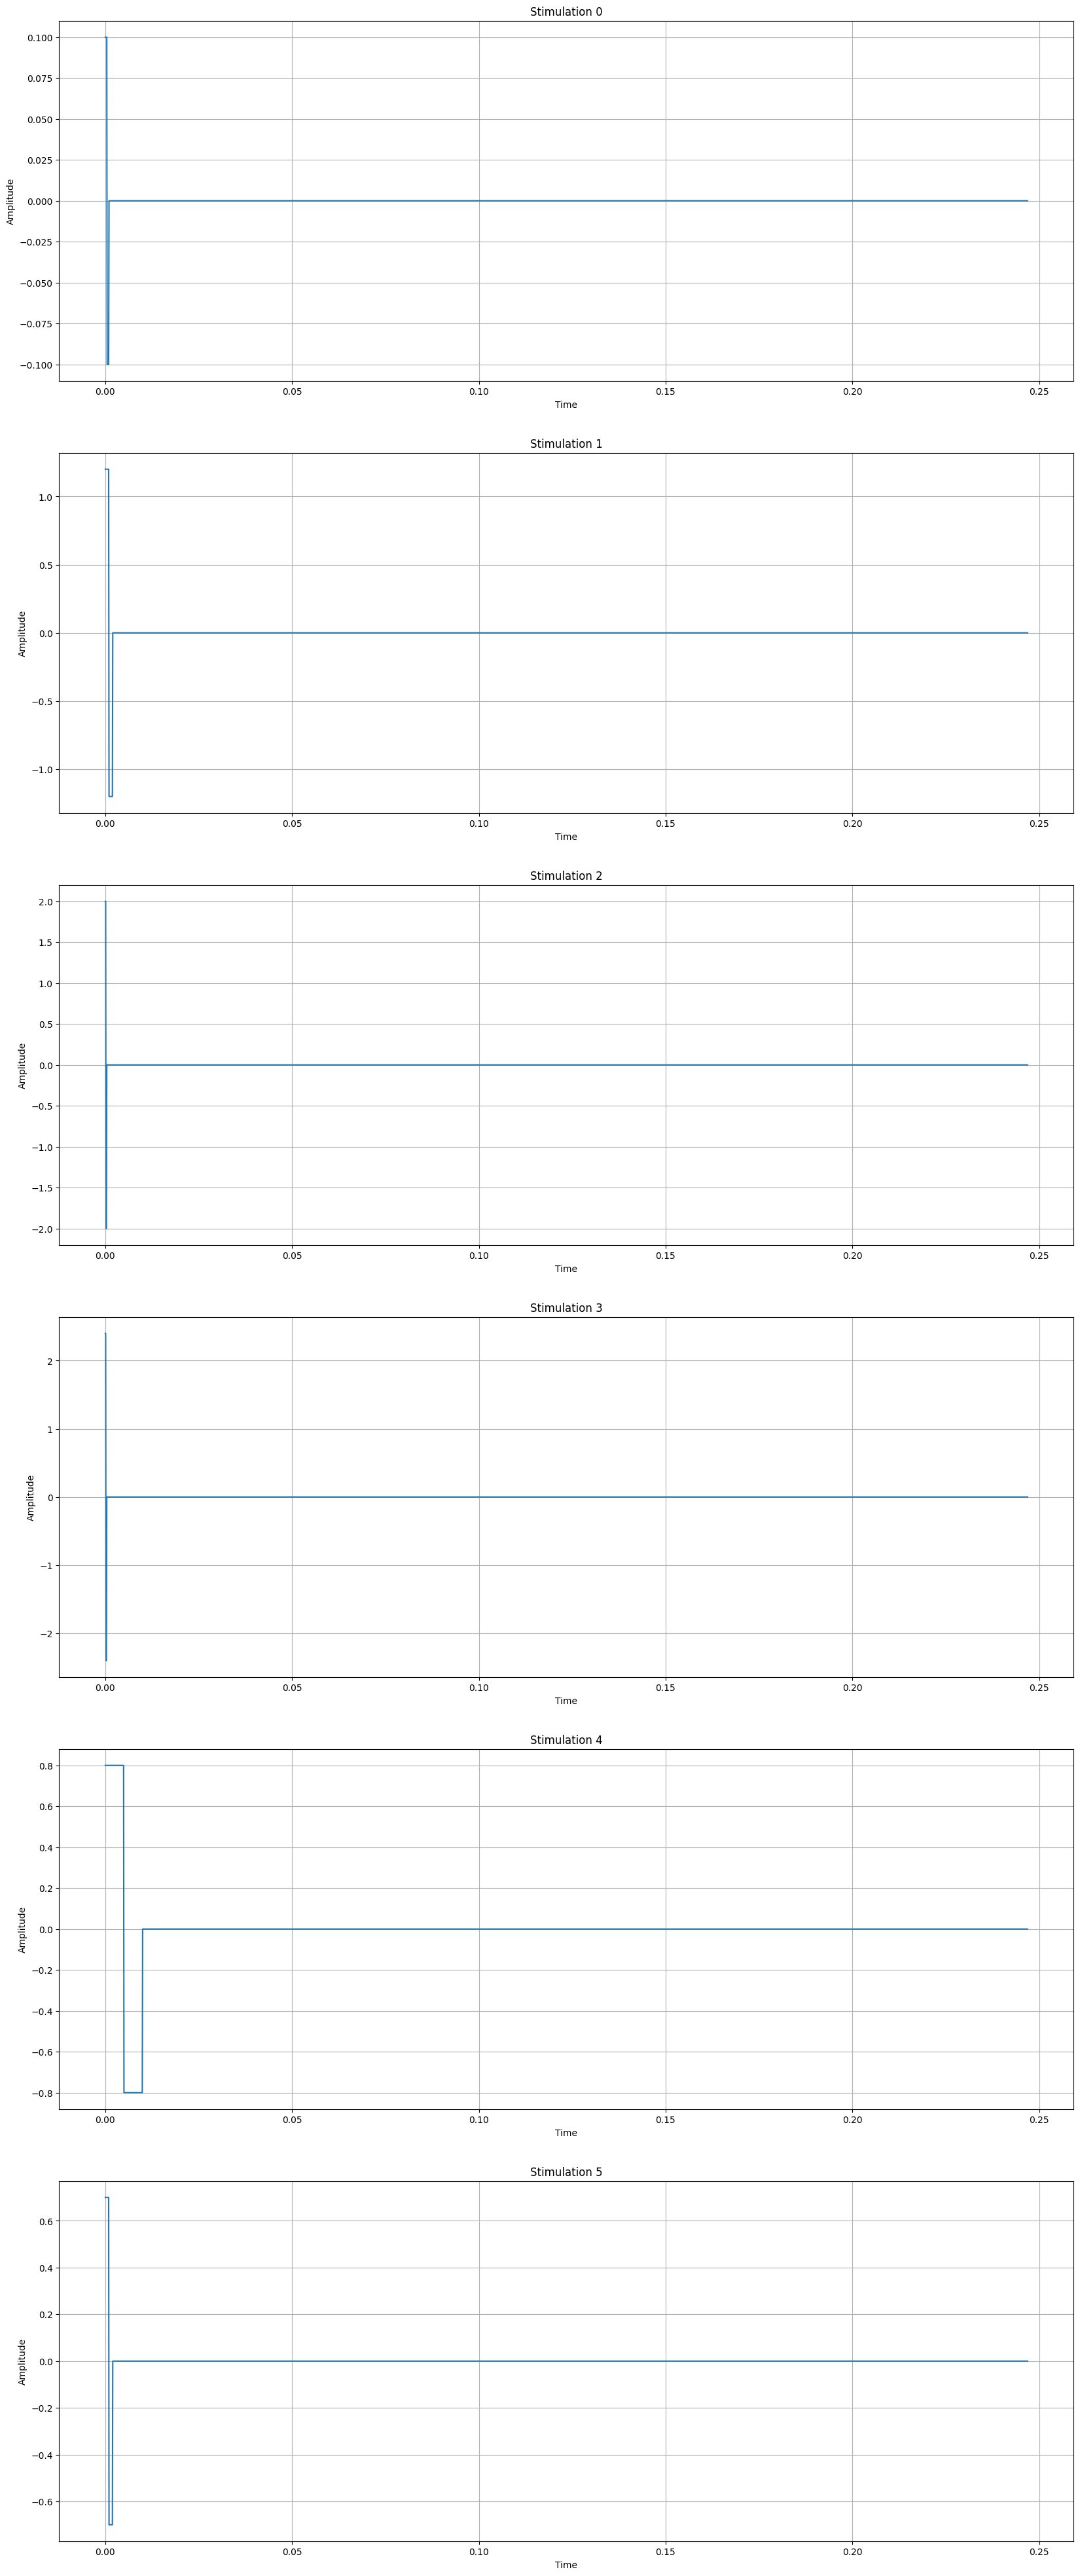

In [25]:
import matplotlib.pyplot as plt

random_idx = np.random.randint(0, len(stimulations), 6)

# plot some stimulations
fig, ax = plt.subplots(6, 1, figsize=(20, 50))

t = np.arange(0, 2470) * 0.0001

for i in range(0, 6):
    ax[i].plot(t, stimulations[random_idx[i]])
    # ax[i].set_xlim([0, 0.15])
    ax[i].set_title('Stimulation {}'.format(i))
    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Amplitude')
    ax[i].grid(True)

In [26]:
import pandas as pd

stimulations_df = pd.DataFrame(stimulations)
stimulations_df.to_csv('data/i2Move/vn_stimulations.csv', index=False)